## Capstone 1 Project: Prediction of Churn for Telecom Customers (Inferential Statistics)

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest as pz


csvfile = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(csvfile)

df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
null_list = df[df['TotalCharges'].isnull()].index.tolist()
df = df.dropna()

plt.style.use('ggplot')

/Users/albertchiu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [3]:
# creating separate dataframes for churn and nonchurn customers
churn_df = df[df.Churn == 'Yes']
nochurn_df = df[df.Churn == 'No']

#### 1. Using alpha = 0.05, is there a significant difference in the monthly charges of churn customers vs non-churn customers?

H0: There is no significant difference in the monthly charges of churn customers vs non-churn customers.

Ha: There is a significant difference in the monthly charges of churn customers vs non-churn customers.

In [4]:
# writing functions for bootstrap method
def bootstrap_replicate(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def bootstrap(category):

    bs_replicates_churn = np.empty(10000)
    bs_replicates_nochurn = np.empty(10000)

    for i in range(10000):
        bs_replicates_churn[i] = bootstrap_replicate(churn_df[category], np.mean)
    
    for i in range(10000):
        bs_replicates_nochurn[i] = bootstrap_replicate(nochurn_df[category], np.mean)

    boot_conf_int = np.percentile(bs_replicates_churn, [2.5, 97.5])

    print('Churn customer', category, 'mean:', bs_replicates_churn.mean().round(3))
    print('Churn customer', category, 'std dev:', bs_replicates_churn.std().round(3), '\n')
    print('Non-churn customer', category, 'mean:', bs_replicates_nochurn.mean().round(3))
    print('Non-churn customer', category, 'std dev:', bs_replicates_nochurn.std().round(3), '\n')

    if bs_replicates_nochurn.mean().round(3) in boot_conf_int:
        print('Non-churn customer', category, 'is/are within the 95% CI of churn customer', category, '.')
    else:
        print('Non-churn customer', category, 'is/are outside the 95% CI of churn customer', category + '.')

In [5]:
# bootstrap method for monthly charges
bootstrap('MonthlyCharges')

Churn customer MonthlyCharges mean: 74.446
Churn customer MonthlyCharges std dev: 0.573 

Non-churn customer MonthlyCharges mean: 61.307
Non-churn customer MonthlyCharges std dev: 0.435 

Non-churn customer MonthlyCharges is/are outside the 95% CI of churn customer MonthlyCharges.


In [6]:
# frequentist method with two sample z-test
stat, pval = st.ttest_ind(churn_df.MonthlyCharges, nochurn_df.MonthlyCharges)
print('P-value:', pval)

P-value: 6.760843117980302e-60


Using both bootstrap and frequentist method, we can reject the null hypothesis and accept the alternative hypothesis that churn and non-churn customers have statistically different mean monthly charges.

#### 2. Using alpha = 0.05, is there a significant difference in the tenure of churn customers vs non-churn customers?

H0: There is no significant difference in the tenure of churn customers vs non-churn customers.

Ha: There is a significant difference in the tenure charges of churn customers vs non-churn customers.

In [7]:
# bootstrap method
bootstrap('tenure')

Churn customer tenure mean: 17.977
Churn customer tenure std dev: 0.454 

Non-churn customer tenure mean: 37.651
Non-churn customer tenure std dev: 0.335 

Non-churn customer tenure is/are outside the 95% CI of churn customer tenure.


In [8]:
# frequentist method with two sample z-test
stat, pval = st.ttest_ind(churn_df.tenure, nochurn_df.tenure)
print('P-value:', pval)

P-value: 9.437650217574845e-207


Using both bootstrap and frequentist method, we can reject the null hypothesis and accept the alternative hypothesis that churn and non-churn customers have statistically different mean tenure.

#### 3. Heat map of numerical data

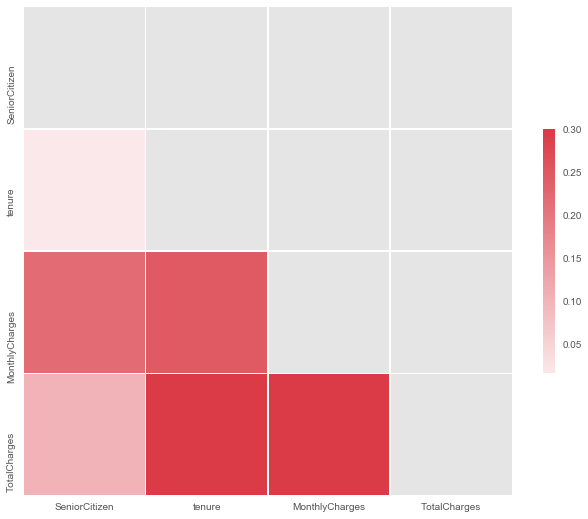

In [52]:
corr = df.corr()

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### 4. Using alpha = 0.05, is there a significant difference in the percentage of churn customers and non-churn customers in choosing fiber optic internet service?

H0: There is no significant difference in the percentage of churn customers vs non-churn customers that use fiber optic for internet service.

Ha: There is a significant difference in the percentage of churn customers vs non-churn customers that use fiber optic for internet service.

In [46]:
# number of churn and non-churn customers using fiber optic internet service
churn_fiber_optic = churn_df.InternetService[churn_df.InternetService == 'Fiber optic'].count()
nochurn_fiber_optic = nochurn_df.InternetService[nochurn_df.InternetService == 'Fiber optic'].count()

# calculating p-value
stat, pval = pz(np.array([churn_fiber_optic, nochurn_fiber_optic]), np.array([len(churn_df),len(nochurn_df)]), value = 0)
print('P-value:', pval)

P-value: 1.3792417311863573e-146


The p-value is less than alpha = 0.05.  Therefore, we can reject the null hypothesis and accept the alternative hypothesis that percentage of 

#### 5. Using alpha = 0.05, is there a significant difference in the percentage of customers that churn by gender?

H0: There is no significant difference in the percentage of customers that churn by gender.

Ha: There is a significant difference in the percentage of customers that churn by gender.

In [47]:
# number of churn and non-churn customers using fiber optic internet service
female_churn = churn_df.gender[churn_df.gender == 'Female'].count()
male_churn = churn_df.gender[churn_df.gender == 'Male'].count()

# calculating p-value
stat, pval = pz(np.array([female_churn, male_churn]), np.array([len(df[df.gender == 'Female']), len(df[df.gender == 'Male'])]), value = 0)
print('P-value:', pval.round(3))

P-value: 0.474


The p-value is greater than alpha = 0.05.  Therefore, we can accept the null hypothesis that there is no significant difference in the percentage of customers that churn by gender.

#### 6. Using alpha = 0.05, is there a significant difference in the percentage of churn and non-churn customers that are on month-to-month contracts?

H0: There is no significant difference in the percentage of churn and non-churn customers that are on month-to-month contracts.

Ha: There is a significant difference in the percentage of churn and non-churn customers that are on month-to-month contracts.

In [51]:
# number of churn and non-churn customers that are on month-to-month contracts
mo_to_mo_churn = churn_df.Contract[churn_df.Contract == 'Month-to-month'].count()
mo_to_mo_nochurn = nochurn_df.Contract[nochurn_df.Contract == 'Month-to-month'].count()

# calculating p-value
stat, pval = pz(np.array([mo_to_mo_churn, mo_to_mo_nochurn]), np.array([len(churn_df), len(nochurn_df)]), value = 0)
print('P-value:', pval)

P-value: 2.7960092525873125e-252


The p-value is less than alpha = 0.05. Therefore, we can reject the null hypothesis and accept the alternative hypothesis that there is significant difference in the percentage of churn customers and non-churn customers that are on month-to-month contracts.